## Эксперимент предсказания функции синусца с использованием RNN(LSTM) слоя

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pickle
import mlflow
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from mlflow.models import infer_signature
from mlflow.tensorflow import save_model, log_model
import tensorflow as tf
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

## Класс описывающий все изменения с данными и обучением модели

In [32]:
class TimeSeriesPredictor:
    def __init__(self, func: str, epochs: int, n_input: int):
        self.file_path_model = f"models\model_{func}_{str(epochs)}_{n_input}.pkl"
        self.n_input = n_input
        self.train_size = 8000
        self.epochs = epochs
        self.func = func
        self.n_features = 1
        self.data_train, self.data_test, self.target_train, self.target_test = self.preparing_data()
        self.model = self.load_model()
        self.predictions = self.get_predictions()
        

    def save_model_rnn(self):
        with open(self.file_path_model, 'wb') as f:
            model = self.fit_model_lstm()
            pickle.dump(model, f)

    def generator_sinus_data(self):
        x = np.linspace(0, 1000, 10000)
        y = 2 * np.sin(0.1 * x) + np.random.rand(*x.shape) * 0.33
        return y.reshape(-1, 1)

    def generator_pila_data(self):
        x = np.linspace(0, 1000, 10000)
        y = (x % 50) + np.random.rand(*x.shape) * 0.33
        return y.reshape(-1, 1)

    def preparing_data(self):
        if self.func == 'sin':
            data = self.generator_sinus_data()
        elif self.func == 'pila':
            data = self.generator_pila_data()
        all_data = []
        all_targets = []
        for i in range(len(data) - (self.n_input+1)):
            all_data.append(data[i:i + self.n_input])
            all_targets.append(data[i + (self.n_input+1)])

        data_train = np.array(all_data[:self.train_size])
        target_train = np.array(all_targets[:self.train_size])

        data_test = np.array(all_data[self.train_size:])
        target_test = np.array(all_targets[self.train_size:])
        return data_train, data_test, target_train, target_test

    def create_model_lstm(self):
        if self.func == 'pila':
            lstm_model = Sequential()
            lstm_model.add(LSTM(100, activation='relu', input_shape=(self.n_input, self.n_features)))
            lstm_model.add(Dense(1, activation='relu'))
            lstm_model.compile(optimizer='adam', loss='mse')
        elif self.func == 'sin':
            lstm_model = Sequential()
            lstm_model.add(LSTM(100, activation='tanh', input_shape=(self.n_input, self.n_features)))
            lstm_model.add(Dense(1))
            lstm_model.compile(optimizer='SGD', loss='mse')
        return lstm_model

    def fit_model_lstm(self):
        model = self.create_model_lstm()
        model.fit(self.data_train, self.target_train, epochs=self.epochs)
        return model

    def get_predictions(self):
        predictions = self.model.predict(self.data_test)
        return predictions

    def load_model(self):
        if not os.path.exists(self.file_path_model):
            self.save_model_rnn()
        elif not os.path.getsize(self.file_path_model) > 0:
            os.remove(self.file_path_model)
            self.save_model_rnn()

        if os.path.getsize(self.file_path_model) > 0:
            with open(self.file_path_model, "rb") as f:
                unpickler = pickle.Unpickler(f)
                model = unpickler.load()
                return model
    
    def show_result(self, mae):
        fig, ax = plt.subplots(figsize=(20, 5))

        x = np.linspace(0, 1000, len(np.concatenate([self.target_train[6500:], self.target_test])))

        ax.set_title(f"Input shape = {self.n_input}, Mean absolute error = {mae}")
        ax.plot(x[:len(self.target_train[6500:])], self.target_train[6500:], label='train', c='g')
        ax.plot(x[len(self.target_train[6500:]):], self.target_test,  label='target', c='b')
        ax.plot(x[len(self.target_train[6500:]):], self.predictions,  label='prediction', c='r')
        
        plt.legend()
        plt.grid(True)
        plt.show()

    def get_result(self):
        return self.model, self.predictions, self.data_train, self.data_test, self.target_train, self.target_test


## Создание эксперимента в MLflow где будут храниться запуски

In [33]:
mlflow.tensorflow.autolog()
experiment = mlflow.set_experiment("SINUSI")

tf.random.set_seed(1)

## Добавление запусков в эксперимент с различным количеством входов

In [34]:
for i in range(100, 103):
    with mlflow.start_run(run_name="test_sin_rnn123") as run:
        tsp_sin = TimeSeriesPredictor('sin', 3, i+((i%100)*5))
        model, predictions, data_train, data_test, target_train, target_test = tsp_sin.get_result()
        print("HERE", type(model), type(predictions), type(data_train))
        signature = infer_signature(data_test, predictions)
        log_model(model, "model", signature=signature)
        mlflow.log_param("batch_sizi4k", i+((i%100)*5))
        import itertools
        X = data_test.copy()
        data = list()
        for j in range(len(X)):
            data.append(list(itertools.chain.from_iterable(X[j])))
        model_uri = mlflow.get_artifact_uri("model")
        eval_data = pd.DataFrame({"data": data, "target": list(itertools.chain.from_iterable(target_test))})
        result = mlflow.evaluate(
            model=model_uri,
            data=eval_data,
            targets='target',
            model_type="regressor",
            evaluators=["default"],
        )


Epoch 1/3
250/250 [==============================] - 10s 34ms/step - loss: 0.0660
Epoch 2/3
250/250 [==============================] - 9s 34ms/step - loss: 0.0204
Epoch 3/3
1/1 [==============================] - 0s 279ms/step
INFO:tensorflow:Assets written to: C:\Users\Damir4k\AppData\Local\Temp\tmpeke9i5hd\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Damir4k\AppData\Local\Temp\tmpeke9i5hd\model\data\model\assets


60/60 [==============================] - 1s 12ms/step
HERE <class 'keras.src.engine.sequential.Sequential'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
INFO:tensorflow:Assets written to: C:\Users\Damir4k\AppData\Local\Temp\tmp7474esrq\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Damir4k\AppData\Local\Temp\tmp7474esrq\model\data\model\assets
2023/07/23 11:56:54 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.


60/60 [==============================] - 1s 11ms/step


2023/07/23 11:56:55 WARNING mlflow.models.evaluation.default_evaluator: Skip logging model explainability insights because the shap explainer None requires all feature values to be numeric, and each feature column must only contain scalar values.


Epoch 1/3
250/250 [==============================] - 11s 38ms/step - loss: 0.0531
Epoch 2/3
250/250 [==============================] - 9s 38ms/step - loss: 0.0188
Epoch 3/3
1/1 [==============================] - 0s 275ms/step
INFO:tensorflow:Assets written to: C:\Users\Damir4k\AppData\Local\Temp\tmpzpfyggyb\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Damir4k\AppData\Local\Temp\tmpzpfyggyb\model\data\model\assets


60/60 [==============================] - 1s 12ms/step
HERE <class 'keras.src.engine.sequential.Sequential'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
INFO:tensorflow:Assets written to: C:\Users\Damir4k\AppData\Local\Temp\tmp08a8nhw3\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Damir4k\AppData\Local\Temp\tmp08a8nhw3\model\data\model\assets
2023/07/23 11:57:41 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.


60/60 [==============================] - 1s 13ms/step


2023/07/23 11:57:42 WARNING mlflow.models.evaluation.default_evaluator: Skip logging model explainability insights because the shap explainer None requires all feature values to be numeric, and each feature column must only contain scalar values.


Epoch 1/3
250/250 [==============================] - 11s 39ms/step - loss: 0.0452
Epoch 2/3
250/250 [==============================] - 10s 39ms/step - loss: 0.0197
Epoch 3/3
1/1 [==============================] - 0s 278ms/step
INFO:tensorflow:Assets written to: C:\Users\Damir4k\AppData\Local\Temp\tmp0kg3omev\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Damir4k\AppData\Local\Temp\tmp0kg3omev\model\data\model\assets


59/59 [==============================] - 1s 13ms/step
HERE <class 'keras.src.engine.sequential.Sequential'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
INFO:tensorflow:Assets written to: C:\Users\Damir4k\AppData\Local\Temp\tmp17z5gn1a\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Damir4k\AppData\Local\Temp\tmp17z5gn1a\model\data\model\assets
2023/07/23 11:58:29 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.


59/59 [==============================] - 1s 14ms/step


2023/07/23 11:58:30 WARNING mlflow.models.evaluation.default_evaluator: Skip logging model explainability insights because the shap explainer None requires all feature values to be numeric, and each feature column must only contain scalar values.


## Поиск запусков с наилучшими показателями mean absolute error

60/60 [==============================] - 1s 15ms/step


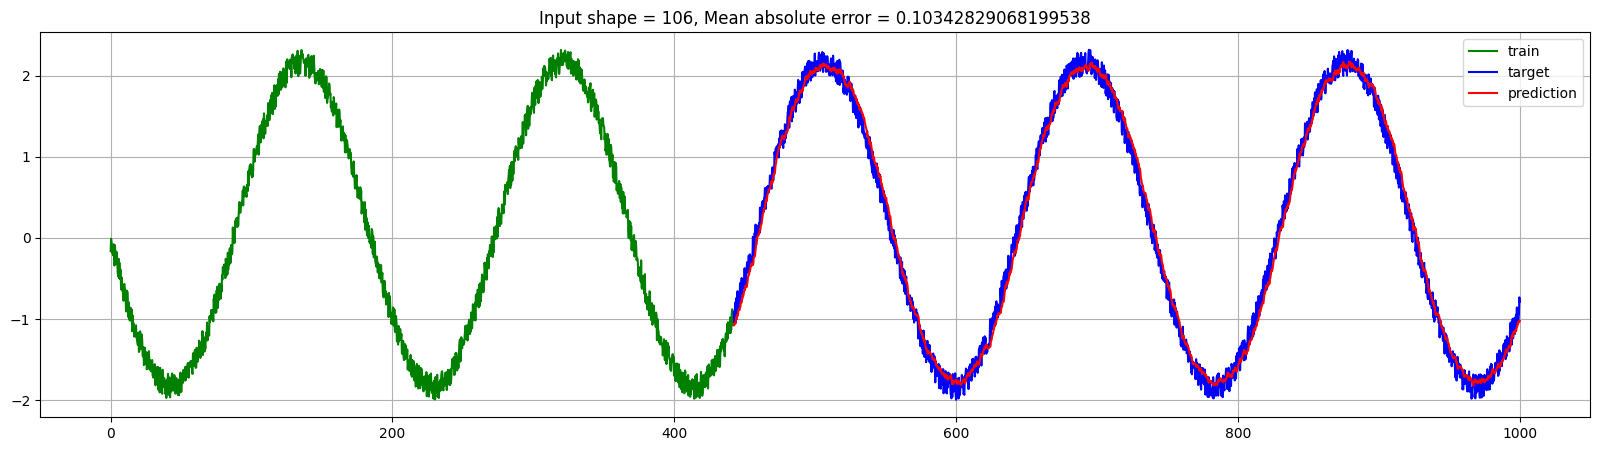

60/60 [==============================] - 1s 13ms/step


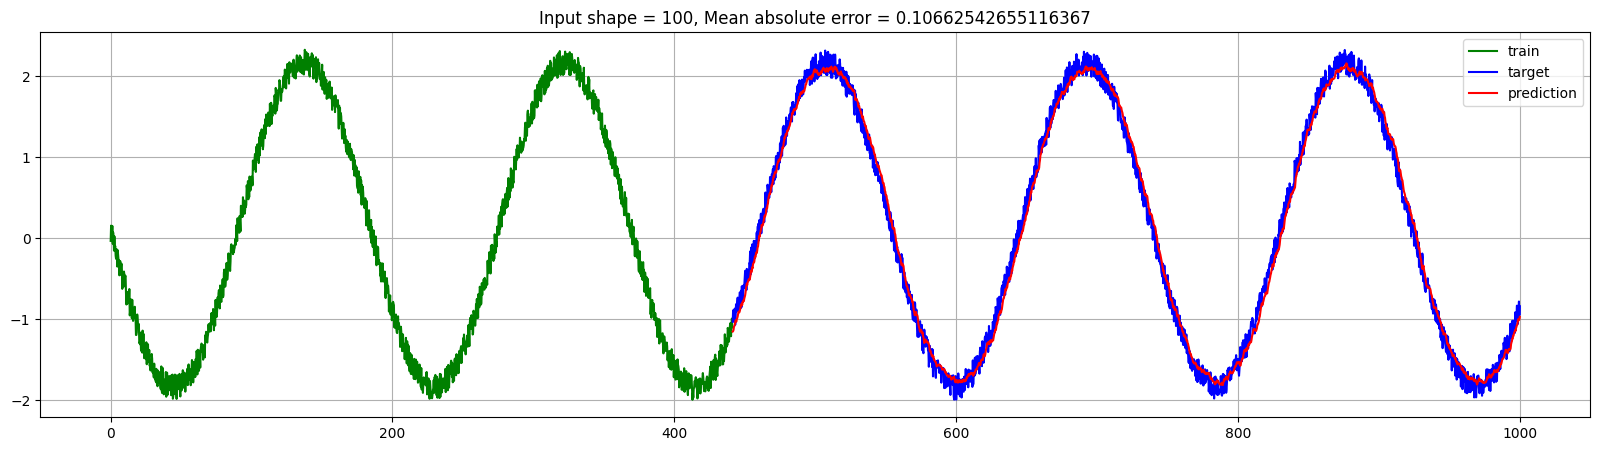

59/59 [==============================] - 1s 16ms/step


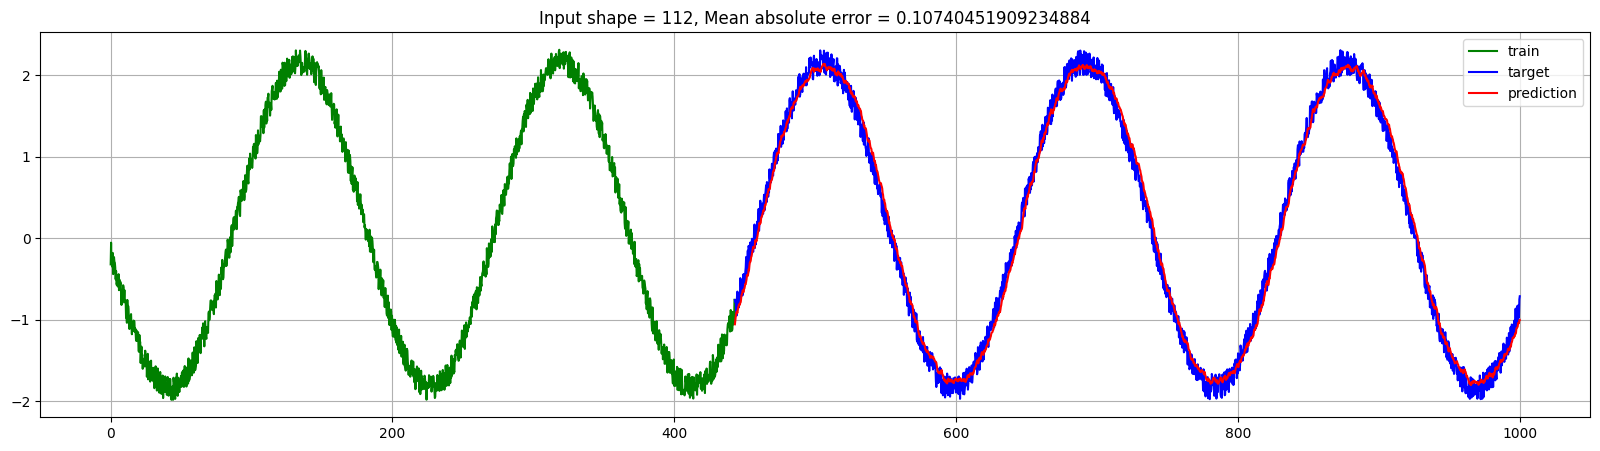

In [35]:
import pprint

from mlflow.entities import ViewType
import mlflow
from mlflow import MlflowClient

run = MlflowClient().search_runs(
    experiment_ids='548219736140986572',
    order_by=["metrics.mean_absolute_error"],
)[:3]

for run1 in run:
    batch_s = run1.data.params['batch_sizi4k']
    mae_metric = run1.data.metrics['mean_absolute_error']

    logged_model = f'runs:/{run1.info.run_id}/model'

    loaded_model = mlflow.pyfunc.load_model(logged_model)
    
    TimeSeriesPredictor('sin', 3, int(batch_s)).show_result(mae_metric)

## Создание эксперимента в MLflow где будут храниться запуски

In [39]:
mlflow.tensorflow.autolog()
experiment = mlflow.set_experiment("PILA")

tf.random.set_seed(1)

## Добавление запусков в эксперимент с различным количеством входов

In [40]:
for i in range(20, 61, 20):
    with mlflow.start_run(run_name="test_pila_rnn") as run:
        tsp_sin = TimeSeriesPredictor('pila', 7, i)
        model, predictions, data_train, data_test, target_train, target_test = tsp_sin.get_result()
        print("HERE", type(model), type(predictions), type(data_train))
        signature = infer_signature(data_test, predictions)
        log_model(model, "model", signature=signature)
        mlflow.log_param("batch_sizi4k", i)
        import itertools
        X = data_test.copy()
        data = list()
        for j in range(len(X)):
            data.append(list(itertools.chain.from_iterable(X[j])))
        model_uri = mlflow.get_artifact_uri("model")
        eval_data = pd.DataFrame({"data": data, "target": list(itertools.chain.from_iterable(target_test))})
        result = mlflow.evaluate(
            model=model_uri,
            data=eval_data,
            targets='target',
            model_type="regressor",
            evaluators=["default"],
        )

Epoch 1/7
250/250 [==============================] - 3s 9ms/step - loss: 21.8671
Epoch 2/7
250/250 [==============================] - 2s 9ms/step - loss: 10.3762
Epoch 3/7
250/250 [==============================] - 2s 9ms/step - loss: 10.4838
Epoch 4/7
250/250 [==============================] - 2s 9ms/step - loss: 10.3144
Epoch 5/7
250/250 [==============================] - 2s 9ms/step - loss: 10.5328
Epoch 6/7
250/250 [==============================] - 2s 9ms/step - loss: 10.2431
Epoch 7/7
1/1 [==============================] - 0s 122ms/step
INFO:tensorflow:Assets written to: C:\Users\Damir4k\AppData\Local\Temp\tmpt8horf_v\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Damir4k\AppData\Local\Temp\tmpt8horf_v\model\data\model\assets


62/62 [==============================] - 0s 4ms/step
HERE <class 'keras.src.engine.sequential.Sequential'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
INFO:tensorflow:Assets written to: C:\Users\Damir4k\AppData\Local\Temp\tmprpzcv7zr\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Damir4k\AppData\Local\Temp\tmprpzcv7zr\model\data\model\assets
2023/07/23 12:11:13 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.


62/62 [==============================] - 0s 3ms/step


2023/07/23 12:11:13 WARNING mlflow.models.evaluation.default_evaluator: Skip logging model explainability insights because the shap explainer None requires all feature values to be numeric, and each feature column must only contain scalar values.


Epoch 1/7
250/250 [==============================] - 5s 18ms/step - loss: 1114.4857
Epoch 2/7
250/250 [==============================] - 5s 18ms/step - loss: 566.0813
Epoch 3/7
250/250 [==============================] - 5s 18ms/step - loss: 23.2326
Epoch 4/7
250/250 [==============================] - 5s 18ms/step - loss: 12.0234
Epoch 5/7
250/250 [==============================] - 5s 18ms/step - loss: 9.9953
Epoch 6/7
250/250 [==============================] - 5s 19ms/step - loss: 10.0909
Epoch 7/7
1/1 [==============================] - 0s 121ms/step
INFO:tensorflow:Assets written to: C:\Users\Damir4k\AppData\Local\Temp\tmpknb61ni4\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Damir4k\AppData\Local\Temp\tmpknb61ni4\model\data\model\assets


62/62 [==============================] - 0s 5ms/step
HERE <class 'keras.src.engine.sequential.Sequential'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
INFO:tensorflow:Assets written to: C:\Users\Damir4k\AppData\Local\Temp\tmpfuhfwkmu\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Damir4k\AppData\Local\Temp\tmpfuhfwkmu\model\data\model\assets
2023/07/23 12:11:58 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.


62/62 [==============================] - 0s 6ms/step


2023/07/23 12:11:58 WARNING mlflow.models.evaluation.default_evaluator: Skip logging model explainability insights because the shap explainer None requires all feature values to be numeric, and each feature column must only contain scalar values.


Epoch 1/7
250/250 [==============================] - 7s 25ms/step - loss: 5155.1494
Epoch 2/7
250/250 [==============================] - 6s 24ms/step - loss: 852.8486
Epoch 3/7
250/250 [==============================] - 6s 24ms/step - loss: 844.3358
Epoch 4/7
250/250 [==============================] - 6s 24ms/step - loss: 836.8818
Epoch 5/7
250/250 [==============================] - 6s 24ms/step - loss: 828.7442
Epoch 6/7
250/250 [==============================] - 6s 24ms/step - loss: 819.4317
Epoch 7/7
1/1 [==============================] - 0s 119ms/step
INFO:tensorflow:Assets written to: C:\Users\Damir4k\AppData\Local\Temp\tmp7f_urnhl\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Damir4k\AppData\Local\Temp\tmp7f_urnhl\model\data\model\assets


61/61 [==============================] - 1s 8ms/step
HERE <class 'keras.src.engine.sequential.Sequential'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
INFO:tensorflow:Assets written to: C:\Users\Damir4k\AppData\Local\Temp\tmprebacqmx\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Damir4k\AppData\Local\Temp\tmprebacqmx\model\data\model\assets
2023/07/23 12:12:53 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.


61/61 [==============================] - 1s 8ms/step


2023/07/23 12:12:54 WARNING mlflow.models.evaluation.default_evaluator: Skip logging model explainability insights because the shap explainer None requires all feature values to be numeric, and each feature column must only contain scalar values.


## Поиск запусков с наилучшими показателями mean absolute error

62/62 [==============================] - 0s 5ms/step


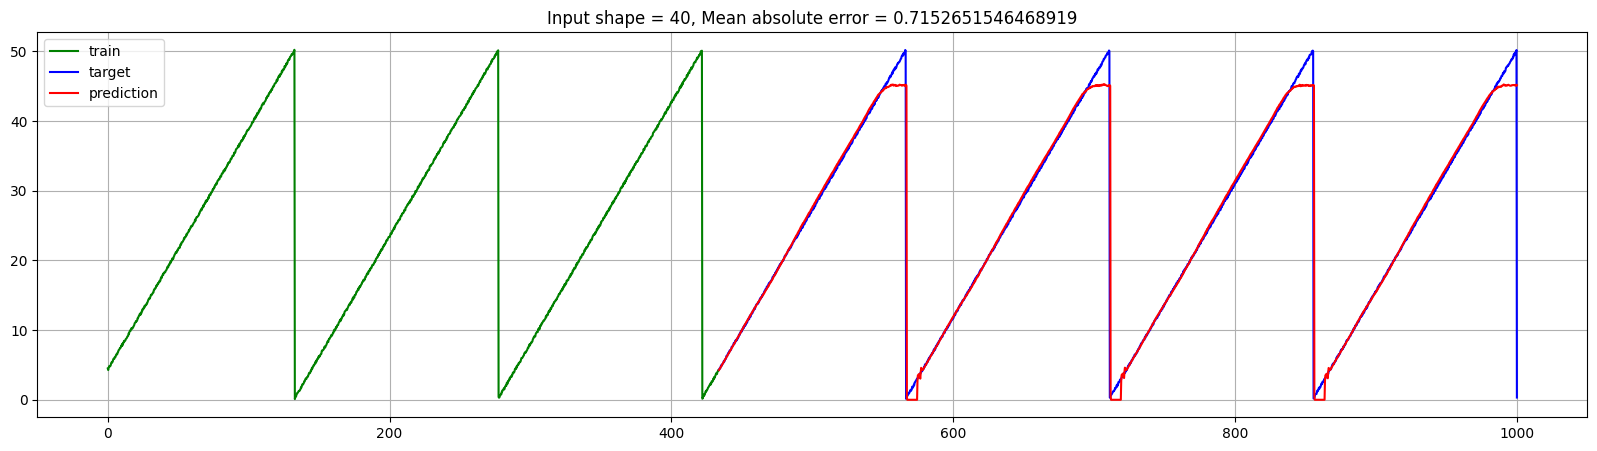

62/62 [==============================] - 0s 3ms/step


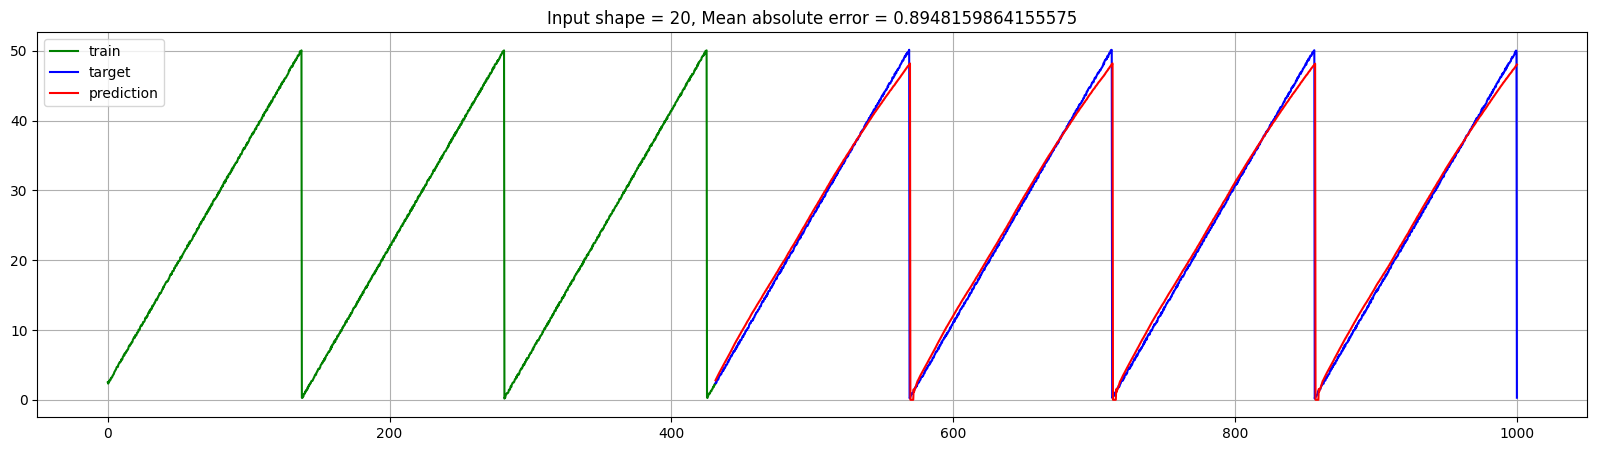

61/61 [==============================] - 1s 7ms/step


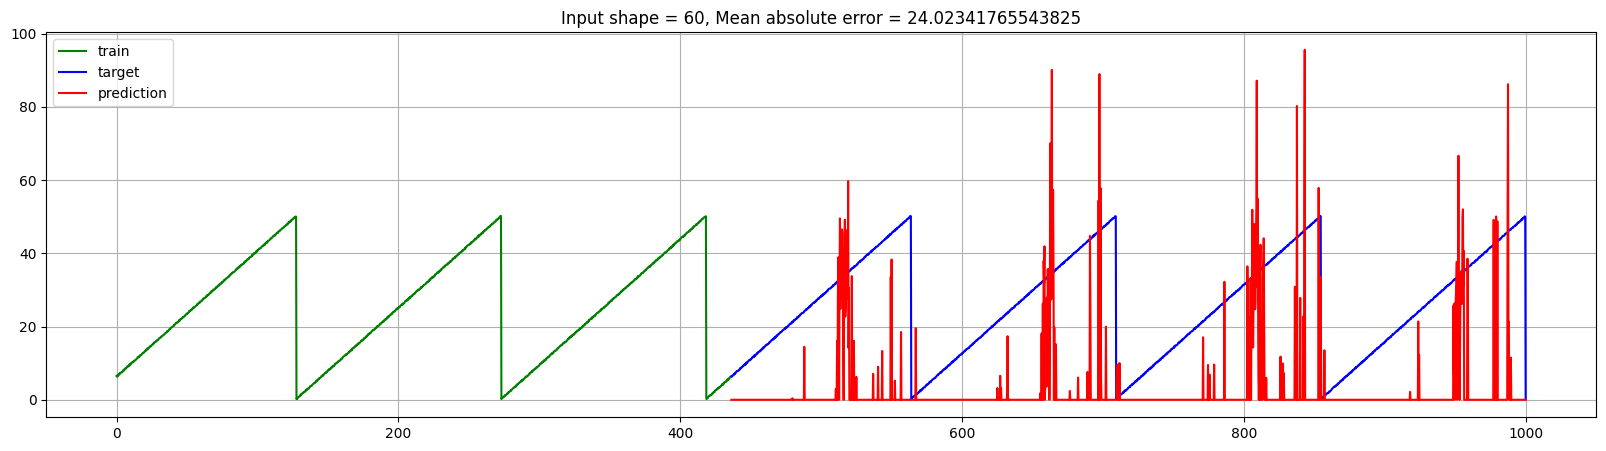

In [41]:
import pprint

from mlflow.entities import ViewType
import mlflow
from mlflow import MlflowClient

run = MlflowClient().search_runs(
    experiment_ids='658074116057026810',
    order_by=["metrics.mean_absolute_error"],
)[:3]

for run1 in run:
    batch_s = run1.data.params['batch_sizi4k']
    mae_metric = run1.data.metrics['mean_absolute_error']

    logged_model = f'runs:/{run1.info.run_id}/model'

    loaded_model = mlflow.pyfunc.load_model(logged_model)
    
    TimeSeriesPredictor('pila', 7, int(batch_s)).show_result(mae_metric)